## The Effect of Management Training for Individual Contributors Transform to Managers

### Dataset

In [1]:
import pandas as pd
import numpy as np
np.random.seed(123)

In [2]:
df = (pd.read_csv("/content/learning_mindset.csv")
      .rename(columns={"schoolid": "departament_id",
                       "achievement_score": "engagement_score",
                       "success_expect": "tenure",
                       "school_achievement": "last_engagement_score",
                       "school_urbanicity": "role",
                       "school_poverty": "department_score",
                       "school_size": "department_size",
                       "ethnicity": "n_of_reports"})
      # reduce overlap for better examples
      .assign(intervention = lambda d: (d["intervention"].astype(bool) | (np.random.normal(d["last_engagement_score"]) > 1.65)).astype(int))
      .assign(intervention = lambda d: (d["intervention"].astype(bool) | (np.random.normal(d["tenure"], 2) > 7)).astype(int))
      .assign(n_of_reports = lambda d: d["n_of_reports"].clip(0, 8))
      .assign(department_size = lambda d: d.groupby("departament_id")["n_of_reports"].transform(sum))
      .assign(last_engagement_score = lambda d: np.random.normal(d["last_engagement_score"]))
      .drop(columns=["frst_in_family", "school_mindset", "school_ethnic_minority"]))


df.to_csv("/content/management_training.csv", index=False)

In [3]:
df1=pd.read_csv("/content/management_training.csv")
df1.head()

,departament_id,intervention,engagement_score,tenure,n_of_reports,gender,role,last_engagement_score,department_score,department_size
0,76,1,0.277359,6,4,2,4,0.614261,0.224077,843
1,76,1,-0.449646,4,8,2,4,0.069636,0.224077,843
2,76,1,0.769703,6,4,2,4,0.866918,0.224077,843
3,76,1,-0.121763,6,4,2,4,0.029071,0.224077,843
4,76,1,1.526147,6,4,1,4,0.589857,0.224077,843


- `intervention`: treatment variable
- `engagement_score`: outcome of interest
  - some ICs want to engage in the activity even without being assigned, while others don't want to go to the training.
- `department_score`:average engagement score in the same department
- `last_engagement_score`:the average score for an manager in previous iteration

### Linear Regression Adjustment for Confounders

In [4]:
import statsmodels.formula.api as smf
smf.ols("engagement_score ~ intervention", data=df1).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.2347,0.014,-16.619,0.000,-0.262,-0.207
intervention,0.4346,0.019,22.616,0.000,0.397,0.472


- The treatment is not random. We need to reduce the bias.
- $engagement_i=τT_i+\theta X_i+e_i$
  - $X$: confounders

In [6]:
model=smf.ols("""
              engagement_score~intervention
              +tenure+last_engagement_score+department_score+n_of_reports+C(gender)+C(role)""", #put categorical variables into C()
              data=df1).fit()
print("ATE:", model.params["intervention"])
print("95% Confident Interval", model.conf_int().loc["intervention", :].values.T)

ATE: 0.26779085766768634
95% Confident Interval [0.23357751 0.30200421]


- Obveriously, the effect of the intervention on engagement is smaller than before.(0.26779086 < 0.4346)
- hence, there exists <u>positive bias</u>. That is, employees who were already engaged are more likely to take participation in the program.

### Propensity Score Estimation

- Balance Score: conditional probability of the treatement, $P(T|X)$, namely, $e(x)$ propensity score

In [7]:
import graphviz as gr

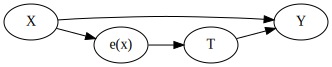

In [8]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "e(x)")
g.edge("e(x)", "T")
g

In [9]:
#owing to binary variable, we need to use logit regression
ps_estimate=smf.logit("""
                      intervention~tenure +
                      last_engagement_score + department_score+
                      C(n_of_reports) + C(gender) + C(role)""", data=df1).fit(disp=0) #disp=0:不显示regression的summary

In [10]:
df_ps=df1.assign(propensity_score=ps_estimate.predict(df1))
df_ps.head()

,departament_id,intervention,engagement_score,tenure,n_of_reports,gender,role,last_engagement_score,department_score,department_size,propensity_score
0,76,1,0.277359,6,4,2,4,0.614261,0.224077,843,0.596106
1,76,1,-0.449646,4,8,2,4,0.069636,0.224077,843,0.391138
2,76,1,0.769703,6,4,2,4,0.866918,0.224077,843,0.602578
3,76,1,-0.121763,6,4,2,4,0.029071,0.224077,843,0.580990
4,76,1,1.526147,6,4,1,4,0.589857,0.224077,843,0.619976


### Orthogonalization

In [11]:
model1=smf.ols("""engagement_score~intervention+propensity_score""", data=df_ps).fit()
model1.params["intervention"]

0.2633126749027707

- The result is very similar to ATE estimated one.(0.2633≈0.26779) There are two alternative methods to adjust for confounders.

### Propensity Score Matching

- Get the *pairs of units* with similar observable characteristics, and compare the outcomes of who recieved the treatment to who did not

In [17]:
from sklearn.neighbors import KNeighborsRegressor
T="intervention"
X="propensity_score"
Y="engagement_score"
treated=df_ps.query(f"{T}==1")
untreated=df_ps.query(f"{T}==0")
m0=KNeighborsRegressor(n_neighbors=1).fit(untreated[[X]], untreated[Y])
m1=KNeighborsRegressor(n_neighbors=1).fit(treated[[X]], treated[Y])
prediction=pd.concat([treated.assign(match=m0.predict(treated[[X]])),
                     untreated.assign(match=m1.predict(untreated[[X]]))])
prediction.head()

,departament_id,intervention,engagement_score,tenure,n_of_reports,gender,role,last_engagement_score,department_score,department_size,propensity_score,match
0,76,1,0.277359,6,4,2,4,0.614261,0.224077,843,0.596106,0.557680
1,76,1,-0.449646,4,8,2,4,0.069636,0.224077,843,0.391138,-0.952622
2,76,1,0.769703,6,4,2,4,0.866918,0.224077,843,0.602578,-0.618381
3,76,1,-0.121763,6,4,2,4,0.029071,0.224077,843,0.580990,-1.404962
4,76,1,1.526147,6,4,1,4,0.589857,0.224077,843,0.619976,0.000354


- With a match of each unit, we can estimate ATE: $\widehat{ATE}=\frac{1}{N}(Y_i-Y_{jm(i)})T_i+(Y_{jm(i)}-Y_i)(1-T_i)$

In [18]:
np.mean((prediction[Y]-prediction["match"])*prediction[T]+(prediction["match"]-prediction[Y])*(1-prediction[T]))

0.28777443474045966

### Inverse Propensity Weighting(IPW)